In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.1 MB/s eta 0:00:00


In [2]:
# Load packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from pathlib import Path
from urllib.request import urlretrieve

# Get Data

In [3]:
SNIPS_DATA_BASE_URL = (
    "https://github.com/ogrisel/slot_filling_and_intent_detection_of_SLU/blob/"
    "master/data/snips/"
)
for filename in ["train", "valid", "test", "vocab.intent", "vocab.slot"]:
    path = Path(filename)
    if not path.exists():
        print(f"Downloading {filename}...")
        urlretrieve(SNIPS_DATA_BASE_URL + filename + "?raw=true", path)

In [4]:
lines_train = Path('train').read_text('utf-8').strip().splitlines()

In [5]:
print(f'First line of training set: {lines_train[0]}.')

First line of training set: Add:O Don:B-entity_name and:I-entity_name Sherri:I-entity_name to:O my:B-playlist_owner Meditate:B-playlist to:I-playlist Sounds:I-playlist of:I-playlist Nature:I-playlist playlist:O <=> AddToPlaylist.


In [6]:
def parse_line(line):
    utterance_data, intent_label = line.split(" <=> ")
    items = utterance_data.split()
    words = [item.rsplit(':', 1)[0] for item in items]
    word_labels = [item.rsplit(':', 1)[1] for item in items]
    return {
        'intent_label': intent_label,
        'words': " ".join(words),
        'words_label': " ".join(word_labels),
        'length': len(words)
    }

In [7]:
parse_line(lines_train[0])

{'intent_label': 'AddToPlaylist',
 'words': 'Add Don and Sherri to my Meditate to Sounds of Nature playlist',
 'words_label': 'O B-entity_name I-entity_name I-entity_name O B-playlist_owner B-playlist I-playlist I-playlist I-playlist I-playlist O',
 'length': 12}

In [8]:
parsed = [parse_line(line) for line in lines_train]
df_train = pd.DataFrame([p for p in parsed if p is not None])

In [9]:
df_train.head(5)

,intent_label,words,words_label,length
0,AddToPlaylist,Add Don and Sherri to my Meditate to Sounds of...,O B-entity_name I-entity_name I-entity_name O ...,12
1,AddToPlaylist,put United Abominations onto my rare groove pl...,O B-entity_name I-entity_name O B-playlist_own...,8
2,AddToPlaylist,add the tune by misato watanabe to the Trapeo ...,O O B-music_item O B-artist I-artist O O B-pla...,10
3,AddToPlaylist,add this artist to my this is miguel bosé play...,O O B-music_item O B-playlist_owner B-playlist...,10
4,AddToPlaylist,add heresy and the hotel choir to the evening ...,O B-entity_name I-entity_name I-entity_name I-...,11


In [10]:
# Count the number of lines by intent label
df_train.intent_label.value_counts()

GetWeather              1900
PlayMusic               1900
BookRestaurant          1873
SearchScreeningEvent    1859
RateBook                1856
SearchCreativeWork      1854
AddToPlaylist           1842
Name: intent_label, dtype: int64

array([[<Axes: title={'center': 'length'}>]], dtype=object)

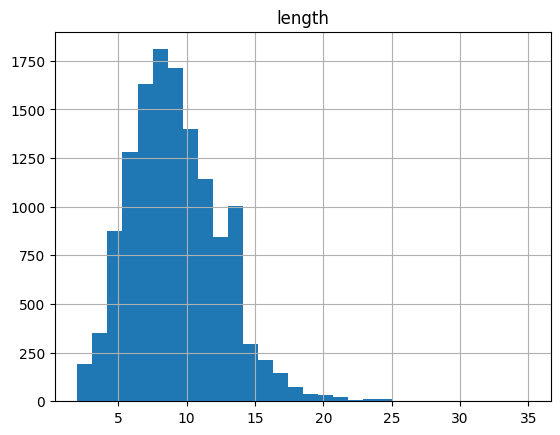

In [11]:
# Histogram of sentence lengths
df_train.hist('length', bins=30)

In [12]:
# Get validation and test set
lines_validation = Path('valid').read_text('utf-8').strip().splitlines()
lines_test = Path('test').read_text('utf-8').strip().splitlines()

df_validation = pd.DataFrame([parse_line(line) for line in lines_validation])
df_test = pd.DataFrame([parse_line(line) for line in lines_test])

# Use Bert Tokenizer

In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

We will tokenize one sample sentence to understand how bert will tokenize sequences

In [14]:
sample_sentence = df_train.words[0]

tokens = tokenizer(sample_sentence)
print(tokens)

{'input_ids': [101, 24930, 1181, 1790, 1105, 1153, 14791, 1106, 1139, 2508, 17903, 2193, 1106, 10560, 1104, 7009, 1505, 7276, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


input_ids are the encoded result of the sequence. We can get the original results by decoding the input_ids

In [15]:
# This is the raw tokenized result (special tokens are added automatically)
print(tokenizer.decode(tokens.input_ids))

[CLS] Add Don and Sherri to my Meditate to Sounds of Nature playlist [SEP]


In [16]:
# If you just want the real sentence without special tokens, set skip_speical_tokens to True
print(tokenizer.decode(tokens.input_ids, skip_special_tokens=True))

Add Don and Sherri to my Meditate to Sounds of Nature playlist


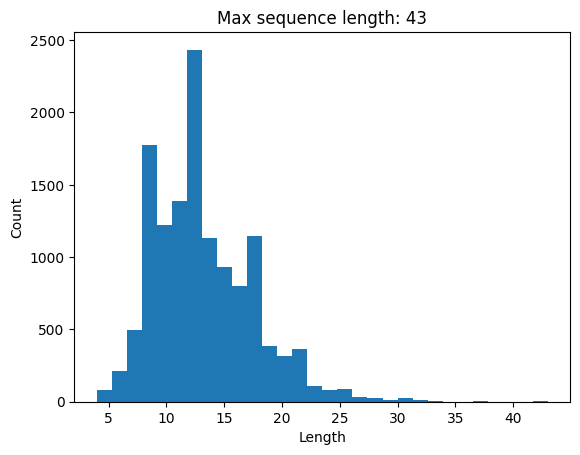

In [17]:
# We need at most 43 tokens to represent all rows in the data
train_sequence_lengths = [len(tokenizer.encode(text))
                          for text in df_train['words']]
plt.hist(train_sequence_lengths, bins=30)
plt.title(f'Max sequence length: {max(train_sequence_lengths)}')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

In [18]:
# In fact, tokenizer automatically does the padding for us
# We can expect that the tokenizer will make all the input have 43 tokens uniformly
encoded_train = tokenizer(df_train.words.values.tolist(), padding="max_length", truncation=True, return_tensors="tf", max_length = max(train_sequence_lengths))
print(encoded_train['input_ids'].shape) # We have a total of 13084 data with a max token length of 43


(13084, 43)


In [19]:
# Continue encoding validation and test
encoded_validation = tokenizer(df_validation.words.values.tolist(), padding="max_length", \
                               truncation=True, return_tensors="tf", max_length = max(train_sequence_lengths))
print(encoded_validation['input_ids'].shape)
encoded_test = tokenizer(df_test.words.values.tolist(), padding="max_length",\
                         truncation=True, return_tensors="tf", max_length = max(train_sequence_lengths))
print(encoded_test['input_ids'].shape)

(700, 43)
(700, 43)


# Use Bert Model


In [20]:
from transformers import TFAutoModel

base_bert_model = TFAutoModel.from_pretrained("bert-base-cased")
base_bert_model.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [21]:
print(encoded_validation.input_ids.shape) # 

(700, 43)


In [22]:
sample_outputs = base_bert_model(encoded_validation)

In [23]:
print(sample_outputs[0])

tf.Tensor(
[[[ 5.44275284e-01  4.76370633e-01 -1.22670773e-02 ... -3.45770001e-01
    2.88329005e-01  6.78885356e-03]
  [ 6.25184774e-01  9.11893472e-02  1.89448744e-01 ...  7.49394715e-01
   -1.27167672e-01  2.20138147e-01]
  [ 7.40410805e-01  2.82061011e-01  1.78167269e-01 ... -4.78687763e-01
   -4.84105259e-01  9.74274501e-02]
  ...
  [-3.02709013e-01  2.40104839e-01 -1.13851540e-02 ...  2.83809334e-01
   -1.54598370e-01  1.86082795e-01]
  [ 2.47940347e-01  1.49826422e-01 -1.90310910e-01 ... -9.67848971e-02
   -2.19059259e-01 -1.90939590e-01]
  [ 2.29154050e-01  1.16105206e-01  1.59489363e-03 ... -3.80369723e-01
    2.80093282e-01 -1.44722089e-01]]

 [[ 4.54779059e-01  1.41496025e-03 -3.63156684e-02 ... -5.16172573e-02
    1.81055158e-01  4.43330780e-02]
  [ 2.48876601e-01 -5.14205843e-02  3.56842041e-01 ...  5.70636451e-01
    1.65070400e-01 -8.62242132e-02]
  [-1.29126593e-01 -2.74420142e-01  1.34658992e-01 ...  1.16108775e+00
   -1.56793565e-01  7.77436793e-02]
  ...
  [-1.657754

In [24]:
# The first output of the BERT model is a tensor with shape: (batch_size, seq_len, output_dim) 
# which computes features for each token in the input sequence.
print(f'Shape of the first output of the BERT model: {sample_outputs[0].shape}.')

Shape of the first output of the BERT model: (700, 43, 768).


In [25]:
# The second output of the BERT model is a tensor with shape (batch_size, output_dim)
# which is the vector representation of the special token [CLS]
print(f'Shape of the second output of the BERT model: {sample_outputs[1].shape}.')

Shape of the second output of the BERT model: (700, 768).


# Setup Labels (Multi class classification)

In [26]:
df_train.intent_label.unique()

array(['AddToPlaylist', 'BookRestaurant', 'GetWeather', 'PlayMusic',
       'RateBook', 'SearchCreativeWork', 'SearchScreeningEvent'],
      dtype=object)

In [27]:
unique_labels = df_train.intent_label.unique()
labels_map = dict((label, idx) for idx, label in enumerate(unique_labels))

In [28]:
labels_map

{'AddToPlaylist': 0,
 'BookRestaurant': 1,
 'GetWeather': 2,
 'PlayMusic': 3,
 'RateBook': 4,
 'SearchCreativeWork': 5,
 'SearchScreeningEvent': 6}

In [29]:
label_train = df_train['intent_label'].map(labels_map).values
print(label_train)

[0 0 0 ... 6 6 6]


In [30]:
train_label_encoded = df_train.intent_label.map(labels_map).values
valid_label_encoded = df_validation.intent_label.map(labels_map).values
test_label_encoded = df_test.intent_label.map(labels_map).values

# Create Model

In [104]:
from keras.layers import Dense, Dropout, Input

# Define IntentClassification model
class BertSingleLabelClassificationModel(tf.keras.Model):
    def __init__(self, num_labels=None,
                 model_name='bert-base-cased',
                 dropout_prob=0.1):
        super().__init__(name='bert_single_label')
        # Let's preload the pretrained model BERT in the constructor
        # of our classifier model.
        self.bert = TFAutoModel.from_pretrained(model_name)
        self.dropout = Dropout(dropout_prob)
        
        # Define a (Dense) classification layer to compute for each
        # sequence in a batch of samples. The number of output classes
        # is given by the intent_num_labels parameter.
        # Use the default linear activation (no softmax) to compute
        # logits. The softmax normalization will be computed in the
        # loss function instead of the model itself.
        self.single_label_classifier = Dense(num_labels)
        
    def call(self, inputs, **kwargs):
        # Use the pretrained model to extract features from our
        # encoded inputs.
        # Bert Model will have two outputs.
        # sequence_output, pooled_output = self.bert(inputs, **kwargs)
        embeddings = self.bert(inputs, **kwargs)
        
        # The second output of the main BERT layer has shape:
        # (batch_size, output_dim) and gives a "pooled" representation
        # for the full sequence from the hidden state that corresponds
        # to the "[CLS]" token.
        pooled_output = self.dropout(embeddings[1], training=kwargs.get('training', False))
        
        # Use the classifier layer to compute the logits from the
        # pooled features.
        label_logits = self.single_label_classifier(pooled_output)
        return label_logits
    


The classification model outputs logits instead of probabilities. The final softmax normalization layer is implicit, that is, included in the loss function instead of the model directly. We need to configure the loss function SparseCategoricalCrossentropy(from_logits=True) accordingly.

In [105]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Build the model
single_label_model = BertSingleLabelClassificationModel(num_labels=len(labels_map))

single_label_model.compile(optimizer=Adam(learning_rate=3e-5, epsilon=1e-08),
                     loss=SparseCategoricalCrossentropy(from_logits=True),
                     metrics=[SparseCategoricalAccuracy('accuracy')])

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [106]:
print(train_label_encoded)

[0 0 0 ... 6 6 6]


In [34]:
history = single_label_model.fit(dict(encoded_train), train_label_encoded, epochs=2, batch_size=32,\
                                 validation_data=(dict(encoded_validation), valid_label_encoded))

Epoch 1/2
409/409 [==============================] - 181s 313ms/step - loss: 0.1753 - accuracy: 0.9424 - val_loss: 0.0548 - val_accuracy: 0.9857
Epoch 2/2
409/409 [==============================] - 125s 306ms/step - loss: 0.0300 - accuracy: 0.9912 - val_loss: 0.0378 - val_accuracy: 0.9900


In [35]:
single_label_model.summary()

Model: "bert_single_label"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model_1 (TFBertMode  multiple                 108310272 
 l)                                                              
                                                                 
 dropout_74 (Dropout)        multiple                  0         
                                                                 
 dense (Dense)               multiple                  5383      
                                                                 
Total params: 108,315,655
Trainable params: 108,315,655
Non-trainable params: 0
_________________________________________________________________


In [69]:
single_label_model.save_weights('ckpt/snips_checkpoint')

In [72]:
# single_label_model.save("snips_tf", save_format='tf')

In [74]:
from tensorflow import keras
load_model = keras.models.load_model("snips_tf")

In [96]:
# This is an empty model
def create_model():
  model = BertSingleLabelClassificationModel(num_labels=len(labels_map))
  model.compile(optimizer=Adam(learning_rate=3e-5, epsilon=1e-08),
                      loss=SparseCategoricalCrossentropy(from_logits=True),
                      metrics=[SparseCategoricalAccuracy('accuracy')])
  return model


In [107]:
checkpoint_path = "ckpt/snips_checkpoint"
load_model = create_model()
load_model.load_weights(checkpoint_path)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### Check performance

In [37]:
df_metric = pd.DataFrame()
df_metric['epoch'] = np.arange(len(history.history['loss']))
df_metric['loss'] = history.history['loss']
df_metric['val_loss'] = history.history['val_loss']
df_metric['accuracy'] = history.history['accuracy']
df_metric['val_accuracy'] = history.history['val_accuracy']

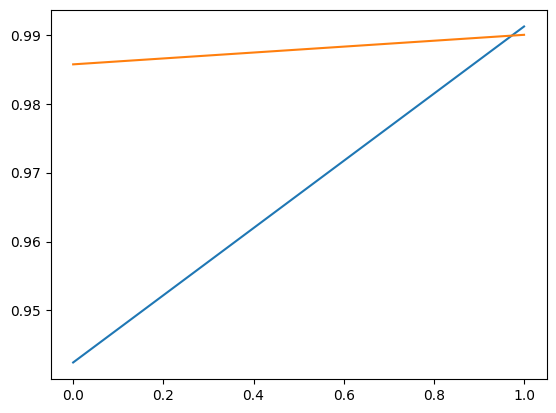

In [44]:
plt.plot(df_metric['epoch'], df_metric['accuracy'])
plt.plot(df_metric['epoch'], df_metric['val_accuracy'])
plt.show()

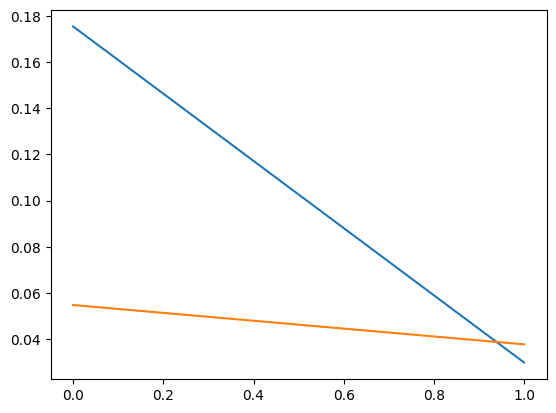

In [45]:
plt.plot(df_metric['epoch'], df_metric['loss'])
plt.plot(df_metric['epoch'], df_metric['val_loss'])
plt.show()

In [85]:
def classify(text, tokenizerzer, model, labels):
    # inputs = tf.constant(tokenizer.encode(text))[None, :] # Batch size = 1
    # inputs = tokenizer(text)
    inputs = tokenizer(text ,padding="max_length", truncation=True, return_tensors="tf", max_length = max(train_sequence_lengths))
    class_id = model(inputs.input_ids).numpy().argmax(axis=1)[0]
    return labels[class_id]

In [102]:
# Example of classification
classify('Hey siri, what is happening today?',
         tokenizer, single_label_model, unique_labels)

'GetWeather'

In [109]:
# Example of classification
classify('Hey siri, why do people fail?',
         tokenizer, load_model, unique_labels)

'SearchScreeningEvent'

In [116]:
input_ids = tf.constant(tokenizer.encode("Hello, my dog is cute"))[None, :]

In [118]:
bert_model = TFAutoModel.from_pretrained("bert-base-cased")
outputs = bert_model([input_ids])

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [122]:
outputs[0]

<tf.Tensor: shape=(1, 8, 768), dtype=float32, numpy=
array([[[ 0.5132387 ,  0.5097057 ,  0.19912963, ..., -0.38999194,
          0.40526906, -0.23153417],
        [ 0.53946257, -0.36580852,  0.66673434, ..., -0.39200175,
          0.25045064,  0.02019704],
        [ 0.7766623 ,  0.68226117,  0.7109604 , ..., -0.04200435,
         -0.3717792 ,  0.37482283],
        ...,
        [ 0.35550088,  0.44857278,  0.61754423, ..., -0.03877966,
         -0.263075  ,  0.35140607],
        [ 0.79272443, -0.1281677 ,  0.2737392 , ..., -0.52195656,
          0.48364452,  0.09373067],
        [ 1.2903223 ,  1.0355561 ,  0.5053781 , ..., -0.43437833,
          1.1972626 , -0.4235853 ]]], dtype=float32)>